In [16]:
from tsplearn import *
import numpy as np 
import pandas as pd

prob_T=0.8

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = B2@G.mask
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(M*sparsity) # Sparsity
sparsity_mode = "max"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5, 26, 4) 
max_iter = 100 
patience = 5 
tol = 1e-7 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

In [43]:
G.mask.sum()

49.0

In [44]:
nu-T

49

In [15]:
np.all(B2_full == B2)

True

In [2]:
gen_params={'dictionary_type':dictionary_type,
        'm_train':m_train,
        'm_test':m_test,
        'P':P,
        'M':M,
        'J':J,
        'sparsity':sparsity,
        'K0_max':K0_max,
        'sparsity_mode':sparsity_mode,
        'n_search':n_search,
        'n_sim':n_sim,
        'prob_T':prob_T}

In [3]:
load_data = generate_data(Lu, Ld, **gen_params)

D_true = load_data['D_true']
Y_train = load_data['Y_train']
Y_test = load_data['Y_test']
X_train = load_data['X_train']
X_test = load_data['X_test']
epsilon_true =  load_data['epsilon_true']
c_true = load_data['c_true']

# Class

In [37]:
import scipy.linalg as sla
import numpy as np
import numpy.linalg as la
import cvxpy as cp
from tsplearn.tsp_generation import *
from tsplearn.tsp_utils import *
from tsplearn.tsp_hodgelet import *  # SeparateHodgelet, SimplicianSlepians
from tsplearn.EnhancedGraph import EnhancedGraph
from typing import Tuple, List, Union, Dict
import pickle
from functools import wraps
from einops import rearrange

def _indicator_matrix(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 0
    return np.diag(tmp)


def _indicator_matrix_rev(row):
    tmp = row.sigma.copy()
    tmp[row.idx] = 1
    return np.diag(tmp)


def _compute_Luj(row, b2, J):
    Lu = b2 @ row.sigma @ b2.T
    Luj = np.array([la.matrix_power(Lu, i) for i in range(1, J + 1)])
    return Luj


def _split_coeffs(h, s, k, sep=False):
    h_tmp = h.value.flatten()
    # hH = h_tmp[:s,].reshape((s,1))
    # hS = h_tmp[s:s*(k+1),].reshape((s,k))
    # hI = h_tmp[s*(k+1):,].reshape((s,k))
    if sep:
        hH = h_tmp[np.arange(0, (s * (2 * k + 1)), (2 * k + 1))].reshape((s, 1))
        hS = h_tmp[
            np.hstack([[i, i + 1] for i in range(1, (s * (2 * k + 1)), (2 * k + 1))])
        ].reshape((s, k))
        hI = h_tmp[
            np.hstack(
                [[i, i + 1] for i in range((k + 1), (s * (2 * k + 1)), (2 * k + 1))]
            )
        ].reshape((s, k))
        return [hH, hS, hI]
    hi = h_tmp[np.arange(0, (s * (k + 1)), (k + 1))].reshape((s, 1))
    h = h_tmp[
        np.hstack([[i, i + 1] for i in range(1, (s * (k + 1)), (k + 1))])
    ].reshape((s, k))
    return np.hstack([h, hi])


def sparse_transform(D, K0, Y_te, Y_tr=None):

    ep = np.finfo(float).eps  # to avoid some underflow problems
    dd = la.norm(D, axis=0) + ep
    W = np.diag(1.0 / dd)
    Domp = D @ W
    X_te = np.apply_along_axis(
        lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_te
    )
    # Normalization
    X_te = W @ X_te

    if np.all(Y_tr == None):

        return X_te

    # Same for the training set
    X_tr = np.apply_along_axis(
        lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_tr
    )
    X_tr = W @ X_tr

    return X_te, X_tr


def compute_vandermonde(L, k):

    def polynomial_exp(x, k):
        x = x ** np.arange(0, k + 1)
        return x

    eigenvalues, _ = sla.eig(L)
    idx = eigenvalues.argsort()
    tmp_df = pd.DataFrame({"Eigs": eigenvalues[idx]})
    tmp_df["Poly"] = tmp_df["Eigs"].apply(lambda x: polynomial_exp(x, k))
    B = np.vstack(tmp_df["Poly"].to_numpy())

    return B


def nmse(D, X, Y, m):
    return (1 / m) * np.sum(la.norm(Y - (D @ X), axis=0) ** 2 / la.norm(Y, axis=0) ** 2)


class TspSolver:

    def __init__(self, X_train, X_test, Y_train, Y_test, *args, **kwargs):

        params = {
            "P": None,  # Number of Kernels (Sub-dictionaries)
            "J": None,  # Polynomial order
            "K0": None,  # Sparsity level
            "dictionary_type": None,
            "c": None,  # spectral control parameter
            "epsilon": None,  # spectral control parameter
            "n": 10,  # number of nodes
            "sub_size": None,  # Number of sub-sampled nodes
            "true_prob_T": 1.0,  # True ratio of colored triangles
            "prob_T": 1.0, # The triangle probability with which we want to bias our topology
            "p_edges": 1.0,  # Probability of edge existence
            "seed": None,  ####
            "option": "One-shot-diffusion",  ####
            "diff_order_sol": 1,  ####
            "diff_order_irr": 1,  ####
            "step_prog": 1,  ####
            "top_k_slepians": 2,  ####
        }

        self.testing_trace = {} ##################################################################

        if args:
            if len(args) != 1 or not isinstance(args[0], dict):
                raise ValueError(
                    "When using positional arguments, must provide a single dictionary"
                )
            params.update(args[0])

        params.update(kwargs)

        # Data
        self.X_train: np.ndarray = X_train
        self.X_test: np.ndarray = X_test
        self.Y_train: np.ndarray = Y_train
        self.Y_test: np.ndarray = Y_test
        self.m_train: int = Y_train.shape[1]
        self.m_test: int = Y_test.shape[1]

        # Topology and geometry behind data (by default we consider a topology with full upper laplacian)
        self.G = EnhancedGraph(
            n=params["n"],
            p_edges=params["p_edges"],
            p_triangles=params["prob_T"],
            seed=params["seed"],
        )
        # Incidence matrices
        self.B1: np.ndarray = self.G.get_b1()
        self.B2: np.ndarray = self.G.get_b2()

        # Sub-sampling if needed to decrease complexity
        if params["sub_size"] != None:
            self.B1 = self.B1[:, : params["sub_size"]]
            self.B2 = self.B2[: params["sub_size"], :]
            self.B2 = self.B2[:, np.sum(np.abs(self.B2), 0) == 3]

        # Topology dimensions and hyperparameters
        self.nu: int = self.B2.shape[1]
        self.nd: int = self.B1.shape[1]
        self.true_prob_T = params["true_prob_T"]
        self.T: int = int(np.ceil(self.nu * (1 - self.true_prob_T)))

        # Laplacians according to the Hodge Theory for cell complexes
        Lu, Ld, L = self.G.get_laplacians(sub_size=params["sub_size"])
        self.Lu: np.ndarray = Lu  # Upper Laplacian
        self.Ld: np.ndarray = Ld  # Lower Laplacian
        self.L: np.ndarray = L  # Sum Laplacian
        self.M = L.shape[0]

        # Dictionary hyperparameters
        self.P = params["P"]  # Number of sub-dicts
        self.J = params["J"]  # Polynomial order for the Hodge Laplacian
        self.c = params["c"]  # Hyperparameter for stability in frequency domain
        self.epsilon = params[
            "epsilon"
        ]  # Hyperparameter for stability in frequency domain
        self.K0 = params["K0"]  # Assumed sparsity level
        self.dictionary_type = params["dictionary_type"]
        # Init optimal values for sparse representations and overcomplete dictionary
        self.D_opt: np.ndarray = np.zeros((self.M, self.M * self.P))
        self.X_opt_train: np.ndarray = np.zeros(self.X_train.shape)
        self.X_opt_test: np.ndarray = np.zeros(self.X_test.shape)
        # Init the learning errors and error curve (history)
        self.min_error_train = 1e20
        self.min_error_test = 1e20
        self.train_history: List[np.ndarray] = []
        self.test_history: List[np.ndarray] = []
        self.opt_upper = self.nu

        ############################################################################################################
        ##                                                                                                        ##
        ##               This section is only for learnable (data-driven) dictionaries                            ##
        ##                                                                                                        ##
        ############################################################################################################

        # Init the dictionary parameters according to the specific parameterization setup
        if self.dictionary_type == "separated":
            hs = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, self.J))
            hh = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hh, hs, hi]
        else:
            h = np.zeros((self.P, self.J))
            hi = np.zeros((self.P, 1))
            self.h_opt: List[np.ndarray] = [hi, h]

        # Compute the polynomial extension for the Laplacians and the auxiliary
        # "pseudo-vandermonde" matrix for the constraints in the quadratic form
        if self.dictionary_type == "joint":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(
                self.L, self.J
            )
            self.B = compute_vandermonde(self.L, self.J).real
        elif self.dictionary_type == "edge_laplacian":
            self.Lj, self.lambda_max_j, self.lambda_min_j = compute_Lj_and_lambdaj(
                self.Ld, self.J
            )
            self.B = compute_vandermonde(self.Ld, self.J).real
        elif self.dictionary_type == "separated":
            self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(
                self.Lu, self.J, separated=True
            )
            self.Ldj, self.lambda_max_d_j, self.lambda_min_d_j = compute_Lj_and_lambdaj(
                self.Ld, self.J, separated=True
            )
            self.Bu = compute_vandermonde(self.Lu, self.J).real
            self.Bd = compute_vandermonde(self.Ld, self.J)[:, 1:].real
            self.B = np.hstack([self.Bu, self.Bd])

        # Auxiliary matrix to define quadratic form dor the dictionary learning step
        self.P_aux: np.ndarray = None
        # Flag variable: the dictionary is learnable or analytic
        self.dict_is_learnable = self.dictionary_type in [
            "separated",
            "joint",
            "edge_laplacian",
        ]

        # Auxiliary tools for the Slepians-based dictionary setup
        if self.dictionary_type == "slepians":
            self.option = params["option"]
            self.diff_order_sol = params["diff_order_sol"]
            self.step_prog = params["step_prog"]
            self.diff_order_irr = params["diff_order_irr"]
            self.source_sol = np.ones((self.nd,))
            self.source_irr = np.ones((self.nd,))
            self.top_K_slepians = params["top_k_slepians"]
            self.spars_level = list(range(10, 80, 10))
            # Remember that this part should be updated if B2 or Lu are updated!
            self.F_sol, self.F_irr = get_frequency_mask(
                self.B1, self.B2
            )  # Get frequency bands
            self.S_neigh, self.complete_coverage = cluster_on_neigh(
                self.B1,
                self.B2,
                self.diff_order_sol,
                self.diff_order_irr,
                self.source_sol,
                self.source_irr,
                self.option,
                self.step_prog,
            )
            self.R = [self.F_sol, self.F_irr]
            self.S = self.S_neigh

        # Auxiliary tools for the Wavelet-based dictionary setup
        elif self.dictionary_type == "wavelet":
            # Remember that this part should be updated if B2 or Lu are updated!
            self.w1 = np.linalg.eigvalsh(self.Lu)
            self.w2 = np.linalg.eigvalsh(self.Ld)

    def update_Lu(self, Lu_new):
        self.Lu = Lu_new
        self.Luj, self.lambda_max_u_j, self.lambda_min_u_j = compute_Lj_and_lambdaj(
            self.Lu, self.J, separated=True
        )
        self.Bu = compute_vandermonde(self.Lu, self.J).real
        self.B = np.hstack([self.Bu, self.Bd])

    @staticmethod
    def _multiplier_search(*arrays, P, c, epsilon):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay == 0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(
                arrays, P=P, mult=mult
            )
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c - epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay * 0
                incr_mult = 1
            if tmp_sum_max < c + epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries > 3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    def init_dict(
        self, h_prior: np.ndarray = None, mode: str = "only_X"
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Initialize the dictionary and the signal sparse representation for the alternating
        optimization algorithm.

        Args:
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            P (int): Number of kernels (sub-dictionaries).
            J (int): Max order of the polynomial for the single sub-dictionary.
            Y_train (np.ndarray): Training data.
            K0 (int): Sparsity of the signal representation.
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            only (str): Type of initialization. Can be one of: "only_X", "all", "only_D".

        Returns:
            Tuple[np.ndarray, np.ndarray, bool]: Initialized dictionary, initialized sparse representation, and discard flag value.
        """

        # If no prior info on the dictionary
        if np.all(h_prior == None):

            # Init Dictionary
            if mode in ["all", "only_D"]:

                discard = 1
                while discard == 1:

                    if self.dictionary_type != "separated":
                        h_prior, discard = self._multiplier_search(
                            self.lambda_max_j,
                            self.lambda_min_j,
                            P=self.P,
                            c=self.c,
                            epsilon=self.epsilon,
                        )
                        self.D_opt = generate_dictionary(h_prior, self.P, self.Lj)

                    else:
                        h_prior, discard = self._multiplier_search(
                            self.lambda_max_d_j,
                            self.lambda_min_d_j,
                            self.lambda_max_u_j,
                            self.lambda_min_u_j,
                            P=self.P,
                            c=self.c,
                            epsilon=self.epsilon,
                        )
                        self.D_opt = generate_dictionary(
                            h_prior, self.P, self.Luj, self.Ldj
                        )

            # Init Sparse Representations
            if mode in ["all", "only_X"]:

                L = self.Ld if self.dictionary_type == "edge_laplacian" else self.L
                _, Dx = sla.eig(L)
                dd = la.norm(Dx, axis=0)
                W = np.diag(1.0 / dd)
                Dx = Dx / la.norm(Dx)
                Domp = Dx @ W
                X = np.apply_along_axis(
                    lambda x: get_omp_coeff(self.K0, Domp.real, x),
                    axis=0,
                    arr=self.Y_train,
                )
                X = np.tile(X, (self.P, 1))
                self.X_opt_train = X

        # Otherwise use prior info about the dictionary to initialize both the dictionary and the sparse representation
        else:

            self.h_opt = h_prior

            if self.dictionary_type == "separated":
                self.D_opt = generate_dictionary(h_prior, self.P, self.Luj, self.Ldj)
                self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_train)
            else:
                self.D_opt = generate_dictionary(h_prior, self.P, self.Lj)
                self.X_opt_train = sparse_transform(self.D_opt, self.K0, self.Y_train)


    def topological_dictionary_learn(
        self,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        step_h: float = 1.0,
        step_x: float = 1.0,
        solver: str = "MOSEK",
        verbose: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, List[float]]:
        """
        Dictionary learning algorithm implementation for sparse representations of a signal on complex regular cellular.
        The algorithm consists of an iterative alternating optimization procedure defined in two steps: the positive semi-definite programming step
        for obtaining the coefficients and dictionary based on Hodge theory, and the Orthogonal Matching Pursuit step for constructing
        the K0-sparse solution from the dictionary found in the previous step, which best approximates the original signal.
        Args:
            Y_train (np.ndarray): Training data.
            Y_test (np.ndarray): Testing data.
            J (int): Max order of the polynomial for the single sub-dictionary.
            M (int): Number of data points (number of nodes in the data graph).
            P (int): Number of kernels (sub-dictionaries).
            D0 (np.ndarray): Initial dictionary.
            X0 (np.ndarray): Initial sparse representation.
            Lu (np.ndarray): Upper Laplacian matrix
            Ld (np.ndarray): Lower Laplacian matrix
            dictionary_type (str): Type of dictionary.
            c (float): Boundary constant from the synthetic data generation process.
            epsilon (float): Boundary constant from the synthetic data generation process.
            K0 (int): Sparsity of the signal representation.
            lambda_ (float, optional): Regularization parameter. Defaults to 1e-3.
            max_iter (int, optional): Maximum number of iterations. Defaults to 10.
            patience (int, optional): Patience for early stopping. Defaults to 10.
            tol (float, optional): Tolerance value. Defaults to 1e-s.
            verbose (int, optional): Verbosity level. Defaults to 0.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            minimum training error, minimum testing error, optimal coefficients, optimal testing sparse representation, and optimal training sparse representation.
        """

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        train_hist = []
        test_hist = []

        if self.dict_is_learnalbe:

            # Init the dictionary and the sparse representation
            D_coll = [
                cp.Constant(self.D_opt[:, (self.M * i) : (self.M * (i + 1))])
                for i in range(self.P)
            ]
            Dsum = cp.Constant(np.zeros((self.M, self.M)))
            h_opt = self.h_opt
            Y = cp.Constant(self.Y_train)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            I = cp.Constant(np.eye(self.M))

            while pat_iter < patience and iter_ <= max_iter:

                # SDP Step
                X = cp.Constant(X_tr)
                if iter_ != 1:
                    D_coll = [
                        cp.Constant(D[:, (self.M * i) : (self.M * (i + 1))])
                        for i in range(self.P)
                    ]
                    Dsum = cp.Constant(np.zeros((self.M, self.M)))

                # Define the objective function
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    # Init the variables
                    h = cp.Variable((self.P, self.J))
                    hI = cp.Variable((self.P, 1))
                    h.value, hI.value = h_opt
                    for i in range(0, self.P):
                        tmp = cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0, self.J):
                            tmp += cp.Constant(self.Lj[j, :, :]) * h[i, j]
                        tmp += I * hI[i]
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])
                    term1 = cp.square(cp.norm((Y - D @ X), "fro"))
                    term2 = cp.square(cp.norm(h, "fro") * lambda_)
                    term3 = cp.square(cp.norm(hI, "fro") * lambda_)
                    obj = cp.Minimize(term1 + term2 + term3)

                else:
                    # Init the variables
                    hI = cp.Variable((self.P, self.J))
                    hS = cp.Variable((self.P, self.J))
                    hH = cp.Variable((self.P, 1))
                    hH.value, hS.value, hI.value = h_opt
                    for i in range(0, self.P):
                        tmp = cp.Constant(np.zeros((self.M, self.M)))
                        for j in range(0, self.J):
                            tmp += (cp.Constant(self.Luj[j, :, :]) * hS[i, j]) + (
                                cp.Constant(self.Ldj[j, :, :]) * hI[i, j]
                            )
                        tmp += I * hH[i]
                        D_coll[i] = tmp
                        Dsum += tmp
                    D = cp.hstack([D_coll[i] for i in range(self.P)])

                    term1 = cp.square(cp.norm((Y - D @ X), "fro"))
                    term2 = cp.square(cp.norm(hI, "fro") * lambda_)
                    term3 = cp.square(cp.norm(hS, "fro") * lambda_)
                    term4 = cp.square(cp.norm(hH, "fro") * lambda_)
                    obj = cp.Minimize(term1 + term2 + term3 + term4)

                # Define the constraints
                constraints = (
                    [D_coll[i] >> 0 for i in range(self.P)]
                    + [(cp.multiply(self.c, I) - D_coll[i]) >> 0 for i in range(self.P)]
                    + [
                        (Dsum - cp.multiply((self.c - self.epsilon), I)) >> 0,
                        (cp.multiply((self.c + self.epsilon), I) - Dsum) >> 0,
                    ]
                )

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f"cp.{solver}"), verbose=False)

                # Dictionary Update
                D = D.value
                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_opt = [
                        h_opt[0] + step_h * (h.value - h_opt[0]),
                        h_opt[1] + step_h * (hI.value - h_opt[1]),
                    ]
                else:
                    h_opt = [
                        h_opt[0] + step_h * (hH.value - h_opt[0]),
                        h_opt[1] + step_h * (hS.value - h_opt[1]),
                        h_opt[2] + step_h * (hI.value - h_opt[2]),
                    ]

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(
                    D, self.K0, self.Y_test, self.Y_train
                )
                # Sparse Representation Update
                X_tr = X_tr + step_x * (X_tr_tmp - X_tr)
                X_te = X_te + step_x * (X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)
                train_hist.append(error_train)
                test_hist.append(error_test)


                # Error Storing
                if (
                    (error_train < self.min_error_train)
                    and (abs(error_train) > np.finfo(float).eps)
                    and (abs(error_train - self.min_error_train) > tol)
                ):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (
                    (error_test < self.min_error_test)
                    and (abs(error_test) > np.finfo(float).eps)
                    and (abs(error_test - self.min_error_test) > tol)
                ):
                    self.h_opt = h_opt
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1

        else:

            # Fourier Dictionary Benchmark
            _, self.D_opt = sla.eigh(self.L)
            self.X_opt_test, self.X_opt_train = sparse_transform(
                self.D_opt, self.K0, self.Y_test, self.Y_train
            )

            # Error Updating
            self.min_error_train = nmse(
                self.D_opt, self.X_opt_train, self.Y_train, self.m_train
            )
            self.min_error_test = nmse(
                self.D_opt, self.X_opt_test, self.Y_test, self.m_test
            )

            train_hist.append(error_train)
            test_hist.append(error_test)

        return self.min_error_test, self.min_error_train, train_hist, test_hist
    

    def _aux_matrix_update(self, X):

        I = [np.eye(self.M)]
        if self.dictionary_type == "separated":
            LLu = [lu for lu in self.Luj]
            LLd = [ld for ld in self.Ldj]
            LL = np.array(I + LLu + LLd)
        else:
            LL = [l for l in self.Lj]
            LL = np.array(I + LL)

        P_aux = np.array(
            [LL @ X[(i * self.M) : ((i + 1) * self.M), :] for i in range(self.P)]
        )
        self.P_aux = rearrange(P_aux, "b h w c -> (b h) w c")

    def topological_dictionary_learn_qp(
        self,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        solver: str = "GUROBI",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, List[float]]:

        # Define hyperparameters
        iter_, pat_iter = 1, 0
        train_hist = []
        test_hist = []

        # Learnable Dictionary -> alternating-direction optimization algorithm
        if self.dict_is_learnable:

            # Init the the sparse representation
            h_opt = np.hstack([h.flatten() for h in self.h_opt]).reshape(-1, 1)
            X_tr = self.X_opt_train
            X_te = self.X_opt_test
            f = 2 if self.dictionary_type == "separated" else 1
            reg = lambda_ * np.eye(self.P * (f * self.J + 1))
            I_s = cp.Constant(np.eye(self.P))
            i_s = cp.Constant(np.ones((self.P, 1)))
            B = cp.Constant(self.B)

            while pat_iter < patience and iter_ <= max_iter:

                # Init variables and parameters
                h = cp.Variable((self.P * (f * self.J + 1), 1))
                self._aux_matrix_update(X_tr)
                h.value = h_opt

                Q = cp.Constant(
                    np.einsum("imn, lmn -> il", self.P_aux, self.P_aux) + reg
                )
                l = cp.Constant(np.einsum("mn, imn -> i", self.Y_train, self.P_aux))

                # Quadratic term
                term2 = cp.quad_form(h, Q, assume_PSD=True)
                # Linear term
                term1 = l @ h
                term1 = cp.multiply(-2, term1)[0]

                obj = cp.Minimize(term2 + term1)

                # Define the constraints
                cons1 = cp.kron(I_s, B) @ h
                cons2 = cp.kron(i_s.T, B) @ h
                constraints = (
                    [cons1 >= 0]
                    + [cons1 <= self.c]
                    + [cons2 >= (self.c - self.epsilon)]
                    + [cons2 <= (self.c + self.epsilon)]
                )

                prob = cp.Problem(obj, constraints)
                prob.solve(solver=eval(f"cp.{solver}"), verbose=False)

                # Update the dictionary

                if self.dictionary_type in ["joint", "edge_laplacian"]:
                    h_tmp = _split_coeffs(h, self.P, self.J)
                    # print(h_tmp.shape)
                    # h_tmp = h.value.reshape(self.P, self.J+1)
                    D = generate_dictionary(h_tmp, self.P, self.Lj)
                    h_opt = h_opt + step_h * (h.value - h_opt)
                else:

                    h_list = _split_coeffs(h, self.P, self.J, sep=True)
                    D = generate_dictionary(h_list, self.P, self.Luj, self.Ldj)
                    h_opt = h_opt + step_h * (h.value - h_opt)

                # OMP Step
                X_te_tmp, X_tr_tmp = sparse_transform(
                    D, self.K0, self.Y_test, self.Y_train
                )
                # Sparse Representation Update
                X_tr = X_tr + step_x * (X_tr_tmp - X_tr)
                X_te = X_te + step_x * (X_te_tmp - X_te)

                # Error Update
                error_train = nmse(D, X_tr, self.Y_train, self.m_train)
                error_test = nmse(D, X_te, self.Y_test, self.m_test)

                train_hist.append(error_train)
                test_hist.append(error_test)

                # Error Storing
                if (
                    (error_train < self.min_error_train)
                    and (abs(error_train) > np.finfo(float).eps)
                    and (abs(error_train - self.min_error_train) > tol)
                ):
                    self.X_opt_train = X_tr
                    self.min_error_train = error_train

                if (
                    (error_test < self.min_error_test)
                    and (abs(error_test) > np.finfo(float).eps)
                    and (abs(error_test - self.min_error_test) > tol)
                ):
                    self.h_opt = (
                        h_list if self.dictionary_type == "separated" else h_opt
                    )
                    self.D_opt = D
                    self.X_opt_test = X_te
                    self.min_error_test = error_test
                    pat_iter = 0

                    if verbose == 1:
                        print("New Best Test Error:", self.min_error_test)
                else:
                    pat_iter += 1

                iter_ += 1

        # Analytic Dictionary -> directly go to OMP step
        else:

            if self.dictionary_type == "fourier":
                # Fourier Dictionary Benchmark
                _, self.D_opt = sla.eigh(self.L)

            elif self.dictionary_type == "slepians":
                SS = SimplicianSlepians(
                    self.B1,
                    self.B2,
                    self.S,
                    self.R,
                    verbose=False,
                    top_K=self.top_K_slepians,
                )
                self.D_opt = SS.atoms_flat

            elif self.dictionary_type == "wavelet":
                SH = SeparateHodgelet(
                    self.B1,
                    self.B2,
                    *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w1))),
                    *log_wavelet_kernels_gen(3, 4, np.log(np.max(self.w2))),
                )
                self.D_opt = SH.atoms_flat
                # print(self.D_opt.shape)

            # OMP
            self.X_opt_test, self.X_opt_train = sparse_transform(
                self.D_opt, self.K0, self.Y_test, self.Y_train
            )
            # Error Updating
            self.min_error_train = nmse(
                self.D_opt, self.X_opt_train, self.Y_train, self.m_train
            )
            self.min_error_test = nmse(
                self.D_opt, self.X_opt_test, self.Y_test, self.m_test
            )
            
            train_hist.append(self.min_error_train)
            test_hist.append(self.min_error_test)

        return self.min_error_test, self.min_error_train, train_hist, test_hist

    def learn_upper_laplacian(
        self,
        Lu_new: np.ndarray = None,
        filter: np.ndarray = 1,
        lambda_: float = 1e-3,
        max_iter: int = 10,
        patience: int = 10,
        tol: float = 1e-7,
        step_h: float = 1.0,
        step_x: float = 1.0,
        mode: str = "optimistic",
        verbose: bool = False,
        warmup: int = 0,
        QP=False
    ):

        assert step_h < 1 or step_h > 0, "You must provide a step-size between 0 and 1."
        assert step_x < 1 or step_x > 0, "You must provide a step-size between 0 and 1."
        assert (mode == "optimistic") or (mode == "pessimistic"), f'{mode} is not a legal mode: "optimistic" or "pessimistic" are the only ones allowed.'

        # Check if we are executing the first recursive iteration
        if np.all(Lu_new == None):
            T = self.B2.shape[1]
            if mode == "optimistic":
                self.opt_upper = self.nu
                filter = np.ones(T)
                self.warmup = 0
            elif mode == "pessimistic":
                self.opt_upper = 0
                filter = np.zeros(T)
                self.update_Lu(np.zeros(self.Lu.shape))  # start with an "empty" upper Laplacian
                self.warmup = warmup
        else:
            self.update_Lu(Lu_new)

        if QP:
            _, _, train_hist, test_hist = self.topological_dictionary_learn_qp(
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
                solver="GUROBI",
            )
        else:
            _, _, train_hist, test_hist = self.topological_dictionary_learn(
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
            )

        self.train_history.append(train_hist)
        self.test_history.append(test_hist)

        search_space = (
            np.where(filter == 1) if mode == "optimistic" else np.where(filter == 0)
        )
        sigmas = pd.DataFrame({"idx": search_space[0]})

        sigmas["sigma"] = sigmas.idx.apply(lambda _: filter)
        if mode == "optimistic":
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix(x), axis=1)
        else:
            sigmas["sigma"] = sigmas.apply(lambda x: _indicator_matrix_rev(x), axis=1)
        sigmas["Luj"] = sigmas.apply(lambda x: _compute_Luj(x, self.B2, self.J), axis=1)
        sigmas["D"] = sigmas.apply(
            lambda x: generate_dictionary(self.h_opt, self.P, x.Luj, self.Ldj), axis=1
        )
        sigmas["X"] = sigmas.D.apply(
            lambda x: sparse_transform(x, self.K0, self.Y_train)
        )
        sigmas["NMSE"] = sigmas.apply(
            lambda x: nmse(x.D, x.X, self.Y_train, self.m_train), axis=1
        )

        if self.warmup > 0:
            candidate_error = sigmas.NMSE.min() - np.finfo(float).eps
            self.warmup -= 1
        else:
            candidate_error = sigmas.NMSE.min()
        idx_min = sigmas.NMSE.idxmin()

        if candidate_error < self.min_error_train:
            S = sigmas.sigma[idx_min]
            Lu_new = self.B2 @ S @ self.B2.T
            filter = np.diagonal(S)

            if mode=="optimistic":
                self.opt_upper -= 1
            else:
                self.opt_upper += 1

            if verbose:
                if mode == "optimistic":
                    print(
                        f"Removing {self.nu - self.opt_upper} triangles from topology... \n ... The min training error: {candidate_error:.3f} !"
                    )
                else:
                    print(
                        f"Adding {self.T - self.opt_upper} triangles to topology... \n ... The min training error: {candidate_error:.3f} !"
                    )

            self.testing_trace[f'{self.opt_upper}'] = (S, Lu_new) # return the filter flattened matrix and the new best Lu_new

            return self.learn_upper_laplacian(
                Lu_new=Lu_new,
                filter=filter,
                lambda_=lambda_,
                max_iter=max_iter,
                patience=patience,
                tol=tol,
                step_h=step_h,
                step_x=step_x,
                mode=mode,
                verbose=verbose,
                QP=QP
            )

        self.B2 = self.B2 @ np.diag(filter)
        return self.min_error_train, self.min_error_test, self.train_history, self.test_history, self.Lu, self.B2
    
    def save_results(func):
        '''Decorator to save intermediate results when testing learning functions
        '''
        @wraps(func)
        def wrapper(self, *args, **kwargs):

            outputs = func(self, *args, **kwargs)
            func_name = func.__name__

            if func_name == "test_topological_dictionary_learn":

                path = os.getcwd()
                dir_path = os.path.join(
                    path, "results", "dictionary_learning", f"{self.dictionary_type}"
                )
                name = f"learn_D_{self.dictionary_type}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": outputs[2],
                    "test_history": outputs[3],
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            elif func_name == "test_topological_dictionary_learn_qp":

                path = os.getcwd()
                dir_path = os.path.join(path, "results", "no_topology_learning")
                name = f"learn_T{int(self.true_prob_T*100)}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": outputs[2],
                    "test_history": outputs[3],
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            elif func_name == "test_learn_upper_laplacian":

                path = os.getcwd()
                dir_path = os.path.join(path, "results", "topology_learning")
                name = f"learn_T{int(self.true_prob_T*100)}"
                filename = os.path.join(dir_path, f"{name}.pkl")
                save_var = {
                    "min_error_test": self.min_error_test,
                    "min_error_train": self.min_error_train,
                    "train_history": self.train_history,
                    "test_history": self.test_history,
                    "Lu_opt": self.Lu,
                    "B2_opt":self.B2,
                    "h_opt": self.h_opt,
                    "X_opt_test": self.X_opt_test,
                    "X_opt_train": self.X_opt_train,
                    "D_opt": self.D_opt,
                }

            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

            try:
                with open(filename, "wb") as file:
                    pickle.dump(save_var, file)
            except IOError as e:
                print(f"An error occurred while writing the file: {e}")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")

            return outputs

        return wrapper
    
    @save_results
    def test_topological_dictionary_learn(
        self,
        mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        solver: str = "MOSEK",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> None:
        
        try:
            self.init_dict(mode=mode)
        except:
            print("Initialization Failed!")
        
        self.topological_dictionary_learn(
            lambda_,
            max_iter,
            patience,
            tol,
            solver,
            step_h,
            step_x,
            verbose
            )
            
    @save_results
    def test_topological_dictionary_learn_qp(
        self,
        mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        solver: str = "GUROBI",
        step_h: float = 1.0,
        step_x: float = 1.0,
        verbose: bool = False,
    ) -> None:
        
        try:
            self.init_dict(mode=mode)
        except:
            print("Initialization Failed!")

        self.topological_dictionary_learn_qp(
            lambda_,
            max_iter,
            patience,
            tol,
            solver,
            step_h,
            step_x,
            verbose
            )
        
    @save_results
    def test_learn_upper_laplacian(
        self,
        init_mode: str = "only_X",
        lambda_: float = 1e-7,
        max_iter: int = 100,
        patience: int = 5,
        tol: float = 1e-7,
        step_h: float = 1.,
        step_x: float = 1.,
        mode: str = "optimistic",
        verbose: bool = True,
        warmup: int = 0,
        QP: bool = True
    ) -> None:

        try:
            self.init_dict(mode=init_mode)
        except:
            print("Initialization Failed!")

        self.learn_upper_laplacian(
            lambda_=lambda_,
            max_iter=max_iter,
            patience=patience,
            tol=tol,
            step_h=step_h,
            step_x=step_x,
            mode=mode,
            verbose=verbose,
            warmup=warmup,
            QP=QP
            )
        
    def get_topology_approx_error(self, Lu_true):
        return np.linalg.norm(Lu_true-self.Lu, ord="fro")
    
    def fit(self, init_mode, algo_type, Lu_true, **hyperparams):

        hp = {"lambda_":1e-3,
              "tol":1e-7,
              "patience":10,
              "max_iter":10,
              "step_x":1.,
              "step_h":1.,
              "QP":True,
              "mode":"optimistic",
              "verbose":False
              }
        
        hp.update(hyperparams)

        try:
            self.init_dict(mode=init_mode)
        except:
            print("Initialization Failed!")
        
        if algo_type == "comp":
            self.learn_upper_laplacian(
                lambda_=hp["lambda_"],
                max_iter=hp["max_iter"],
                patience=hp["patience"],
                tol=hp["tol"],
                step_h=hp["step_h"],
                step_x=hp["step_x"],
                QP=hp["QP"],
            )

        else:
            self.topological_dictionary_learn_qp(
                lambda_=hp["lambda_"],
                max_iter=hp["max_iter"],
                patience=hp["patience"],
                tol=hp["tol"],
                step_h=hp["step_h"],
                step_x=hp["step_x"],
                solver='GUROBI'
            )

        Lu_approx_error = self.get_topology_approx_error(Lu_true=Lu_true)

        return self.min_error_train, self.min_error_test, Lu_approx_error


In [5]:
algo_params = {"lambda_":lambda_,
              "tol":tol,
              "patience":patience,
              "max_iter":max_iter,
              "QP":True,
              "mode":"optimistic"
              }

In [28]:
@final_save
def param_dict_learning(
    X_train,
    X_test,
    Y_train,
    Y_test,
    c_true,
    epsilon_true,
    n_sim,
    topo_params,
    algo_params,
    K0_coll,
    Lu_true,
    prob_T,
    learn_topology=False,
    verbose: bool = True,
):
    """
    Learn the sparse representation and the dictionary atoms with the alternating-direction algorithm,
    for given test and training set, and comparing the performances in terms of training and test
    approximation error for several algorithmic setup, principally differencing by dictionary parameterization:
        - Fourier dictionary parameterization
        - Edge Laplacian dictionary parameterization
        - Joint Hodge Laplacian dictionary parameterization
        - Separated Hodge Laplacian dictionary parameterization
        - (Optionally) Separated Hodge Laplacian dictionary parameterization plus Topology Learning
    """

    min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
    min_error_fou_test = np.zeros((n_sim, len(K0_coll)))
    min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
    min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
    min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
    min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
    min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
    min_error_joint_test = np.zeros((n_sim, len(K0_coll)))
    approx_fou = np.zeros((n_sim, len(K0_coll)))
    approx_sep = np.zeros((n_sim, len(K0_coll)))
    approx_joint = np.zeros((n_sim, len(K0_coll)))
    approx_edge = np.zeros((n_sim, len(K0_coll)))
    approx_comp = np.zeros((n_sim, len(K0_coll)))
    laplacian_fou = np.zeros((n_sim, len(K0_coll)))
    laplacian_sep = np.zeros((n_sim, len(K0_coll)))
    laplacian_joint = np.zeros((n_sim, len(K0_coll)))
    laplacian_edge = np.zeros((n_sim, len(K0_coll)))
    laplacian_comp = np.zeros((n_sim, len(K0_coll)))

    dict_errors = {
        "fou": (min_error_fou_train, min_error_fou_test,approx_fou,laplacian_fou),
        "edge": (min_error_edge_train, min_error_edge_test,approx_edge,laplacian_edge),
        "joint": (min_error_joint_train, min_error_joint_test,approx_joint,laplacian_joint),
        "sep": (min_error_sep_train, min_error_sep_test,approx_sep,laplacian_sep),
    }

    dict_types = {
        "fou": ("Fourier", "fourier"),
        "edge": ("Edge Laplacian", "edge_laplacian"),
        "joint": ("Hodge Laplacian", "joint"),
        "sep": ("Separated Hodge Laplacian", "separated"),
    }

    if learn_topology:
        min_error_complete_train = np.zeros((n_sim, len(K0_coll)))
        min_error_complete_test = np.zeros((n_sim, len(K0_coll)))
        dict_errors["comp"] = (min_error_complete_train, min_error_complete_test,approx_comp, laplacian_comp)
        dict_types["comp"] = (
            "Separated Hodge Laplacian with Topology learning",
            "separated",
        )

    models = {}

    for sim in range(n_sim):

        for k0_index, k0 in tqdm(enumerate(K0_coll)):

            for d in dict_types.items():

                model = TspSolver(
                    X_train=X_train[:, :, sim],
                    X_test=X_test[:, :, sim],
                    Y_train=Y_train[:, :, sim],
                    Y_test=Y_test[:, :, sim],
                    c=c_true[sim],
                    epsilon=epsilon_true[sim],
                    K0=k0,
                    dictionary_type=d[1][1],
                    **topo_params,
                )

                try:

                    dict_errors[d[0]][0][sim, k0_index], dict_errors[d[0]][1][sim, k0_index], dict_errors[d[0]][2][sim, k0_index] = model.fit(d[0], Lu_true, **algo_params)
                    
                    models[f"{sim},{k0_index}"] = model

                    if verbose:
                        print(
                            f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Done! Test Error: {dict_errors[d[0]][1][sim,k0_index]:.3f}"
                        )
                        print(
                            f"Topology Approx. Error: {dict_errors[d[0]][2][sim,k0_index]:.3f}"
                        )
                except:
                    print(
                        f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing {d[1][0]}... Diverged!"
                    )
                    try:
                        (
                            dict_errors[d[0]][0][sim, k0_index],
                            dict_errors[d[0]][1][sim, k0_index],
                        ) = (
                            dict_errors[d[0]][0][sim - 1, k0_index],
                            dict_errors[d[0]][1][sim - 1, k0_index],
                        )
                    except:
                        (
                            dict_errors[d[0]][0][sim, k0_index],
                            dict_errors[d[0]][1][sim, k0_index],
                        ) = (
                            dict_errors[d[0]][0][sim + 1, k0_index],
                            dict_errors[d[0]][1][sim + 1, k0_index],
                        )
                        
    return dict_errors, models

In [33]:
s=6

topo_params = {"J":J,
                "P":P,
                "c":c_true[s],
                "epsilon":epsilon_true[s],
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "K0":K0_coll[0],
                "p_edges":0.162,
                "dictionary_type": dictionary_type
                }

In [47]:
topoX = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

In [ ]:
topoX.G.Lu == Lu

In [38]:
topoX2 = TspSolver(X_train=X_train[:, :, s], 
                X_test=X_test[:, :, s], 
                Y_train=Y_train[:, :, s], 
                Y_test=Y_test[:, :, s],
                **topo_params)

topoX2.test_learn_upper_laplacian()

Removing 1 triangles from topology... 
 ... The min training error: 0.076 !
Removing 2 triangles from topology... 
 ... The min training error: 0.075 !
Removing 3 triangles from topology... 
 ... The min training error: 0.074 !
Removing 4 triangles from topology... 
 ... The min training error: 0.074 !
Removing 5 triangles from topology... 
 ... The min training error: 0.072 !
Removing 6 triangles from topology... 
 ... The min training error: 0.071 !
Removing 7 triangles from topology... 
 ... The min training error: 0.069 !
Removing 8 triangles from topology... 
 ... The min training error: 0.067 !
Removing 9 triangles from topology... 
 ... The min training error: 0.064 !
Removing 10 triangles from topology... 
 ... The min training error: 0.062 !
Removing 11 triangles from topology... 
 ... The min training error: 0.061 !


In [40]:
topoX2.get_topology_approx_error(Lu)

14.422205101855956

In [49]:
np.linalg.norm(topoX.Lu-Lu_full, ord="fro")

0.0

In [52]:


topo_params = {"J":J,
                "P":P,
                "true_prob_T":prob_T,
                "sub_size":100,
                "seed":0,
                "n":40,
                "p_edges":0.162,
                }

In [45]:
topoX2.G.mask.sum()

62.0

In [81]:
import warnings
warnings.filterwarnings("ignore")

res, models = param_dict_learning(
    X_train,
    X_test,
    Y_train,
    Y_test,
    c_true,
    epsilon_true,
    n_sim,
    topo_params,
    algo_params,
    K0_coll,
    Lu,
    prob_T,
    learn_topology=True
)

0it [00:00, ?it/s]

Simulation: 1/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.287
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.150
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.122
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.076
Topology Approx. Error: 11.790


1it [04:16, 256.32s/it]

Simulation: 1/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.057
Topology Approx. Error: 14.422
Simulation: 1/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.166
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.074
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.052
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.029
Topology Approx. Error: 11.790


2it [12:21, 391.19s/it]

Simulation: 1/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.018
Topology Approx. Error: 14.731
Simulation: 1/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.105
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.040
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 11.790


3it [22:53, 501.13s/it]

Simulation: 1/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.007
Topology Approx. Error: 14.731
Simulation: 1/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.069
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.024
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790


4it [26:51, 397.11s/it]

Simulation: 1/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.048
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790


5it [31:07, 346.29s/it]

Simulation: 1/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.035
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 11.790
Simulation: 1/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.006
Topology Approx. Error: 11.790


6it [37:07, 371.31s/it]


Simulation: 1/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 11.790


0it [00:00, ?it/s]

Simulation: 2/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.291
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 5 Testing Edge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.141
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.089
Topology Approx. Error: 11.790


1it [04:44, 284.76s/it]

Simulation: 2/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.067
Topology Approx. Error: 14.731
Simulation: 2/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.166
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.080
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.067
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.046
Topology Approx. Error: 11.790


2it [12:07, 377.91s/it]

Simulation: 2/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.025
Topology Approx. Error: 13.964
Simulation: 2/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.105
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.044
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.036
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.026
Topology Approx. Error: 11.790


3it [23:07, 506.43s/it]

Simulation: 2/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 14.731
Simulation: 2/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.071
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 17 Testing Edge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 17 Testing Hodge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.019
Topology Approx. Error: 11.790


4it [34:53, 585.15s/it]

Simulation: 2/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.010
Topology Approx. Error: 14.422
Simulation: 2/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.048
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 21 Testing Edge Laplacian... Diverged!
Simulation: 2/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 11.790


5it [48:29, 668.53s/it]

Simulation: 2/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 13.601
Simulation: 2/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.034
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 2/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 11.790


6it [1:09:02, 690.46s/it]


Simulation: 2/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.005
Topology Approx. Error: 14.731


0it [00:00, ?it/s]

Simulation: 3/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.288
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.151
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.117
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.093
Topology Approx. Error: 11.790


1it [04:33, 273.91s/it]

Simulation: 3/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.079
Topology Approx. Error: 14.491
Simulation: 3/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.167
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.080
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 9 Testing Hodge Laplacian... Diverged!
Simulation: 3/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.037
Topology Approx. Error: 11.790


2it [11:05, 343.04s/it]

Simulation: 3/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.028
Topology Approx. Error: 14.036
Simulation: 3/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.104
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.050
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 13 Testing Hodge Laplacian... Diverged!
Simulation: 3/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.034
Topology Approx. Error: 11.790


3it [21:10, 462.80s/it]

Simulation: 3/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 14.731
Simulation: 3/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.071
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.031
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 17 Testing Hodge Laplacian... Diverged!
Simulation: 3/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.023
Topology Approx. Error: 11.790


4it [32:02, 537.62s/it]

Simulation: 3/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 14.107
Simulation: 3/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.050
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 21 Testing Hodge Laplacian... Diverged!
Simulation: 3/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790


5it [41:33, 549.32s/it]

Simulation: 3/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 12.845
Simulation: 3/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.035
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 11.790
Simulation: 3/10 Sparsity: 25 Testing Hodge Laplacian... Diverged!
Simulation: 3/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790


6it [58:21, 583.53s/it]


Simulation: 3/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 14.422


0it [00:00, ?it/s]

Simulation: 4/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.307
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.181
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.144
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.086
Topology Approx. Error: 11.790


1it [04:33, 273.80s/it]

Simulation: 4/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.060
Topology Approx. Error: 14.422
Simulation: 4/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.184
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.096
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.068
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.038
Topology Approx. Error: 11.790


2it [11:18, 350.67s/it]

Simulation: 4/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.020
Topology Approx. Error: 14.422
Simulation: 4/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.117
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.051
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.037
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.019
Topology Approx. Error: 11.790


3it [20:10, 433.64s/it]

Simulation: 4/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 14.036
Simulation: 4/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.079
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.032
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790


4it [32:01, 542.93s/it]

Simulation: 4/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.005
Topology Approx. Error: 14.422
Simulation: 4/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.054
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 11.790


5it [46:37, 663.15s/it]

Simulation: 4/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.003
Topology Approx. Error: 14.036
Simulation: 4/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.038
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790
Simulation: 4/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.005
Topology Approx. Error: 11.790


6it [1:05:11, 651.87s/it]


Simulation: 4/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.002
Topology Approx. Error: 14.422


0it [00:00, ?it/s]

Simulation: 5/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.299
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.170
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.144
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.111
Topology Approx. Error: 11.790


1it [04:20, 260.85s/it]

Simulation: 5/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.087
Topology Approx. Error: 14.422
Simulation: 5/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.166
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.080
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.064
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.050
Topology Approx. Error: 11.790


2it [11:59, 377.00s/it]

Simulation: 5/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.032
Topology Approx. Error: 14.731
Simulation: 5/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.103
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.043
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.035
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.029
Topology Approx. Error: 11.790


3it [22:16, 486.62s/it]

Simulation: 5/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 14.731
Simulation: 5/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.065
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.026
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 11.790


4it [35:26, 606.42s/it]

Simulation: 5/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 14.422
Simulation: 5/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.044
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790


5it [42:09, 533.15s/it]

Simulation: 5/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.013
Topology Approx. Error: 12.042
Simulation: 5/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.032
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 25 Testing Edge Laplacian... Diverged!
Simulation: 5/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790
Simulation: 5/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790


6it [45:41, 457.00s/it]


Simulation: 5/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.012
Topology Approx. Error: 11.790


0it [00:00, ?it/s]

Simulation: 6/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.301
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.158
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.100
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.074
Topology Approx. Error: 11.790


1it [04:40, 280.72s/it]

Simulation: 6/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.058
Topology Approx. Error: 14.283
Simulation: 6/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.173
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.086
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 9 Testing Hodge Laplacian... Diverged!
Simulation: 6/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.029
Topology Approx. Error: 11.790


2it [12:21, 386.40s/it]

Simulation: 6/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.016
Topology Approx. Error: 14.731
Simulation: 6/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.108
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.054
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.023
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 11.790


3it [23:14, 508.30s/it]

Simulation: 6/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 14.731
Simulation: 6/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.068
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.033
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.017
Topology Approx. Error: 11.790


4it [26:08, 376.17s/it]

Simulation: 6/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.017
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.044
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 11.790


5it [42:56, 604.18s/it]

Simulation: 6/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.003
Topology Approx. Error: 14.731
Simulation: 6/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.031
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 25 Testing Edge Laplacian... Diverged!
Simulation: 6/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.006
Topology Approx. Error: 11.790
Simulation: 6/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790


6it [1:02:06, 621.02s/it]


Simulation: 6/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.002
Topology Approx. Error: 14.731


0it [00:00, ?it/s]

Simulation: 7/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.344
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.181
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.132
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.083
Topology Approx. Error: 11.790


1it [04:56, 296.88s/it]

Simulation: 7/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.060
Topology Approx. Error: 14.422
Simulation: 7/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.199
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.096
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.065
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.037
Topology Approx. Error: 11.790


2it [12:30, 389.03s/it]

Simulation: 7/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.024
Topology Approx. Error: 14.731
Simulation: 7/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.127
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.054
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.037
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 11.790


3it [22:30, 485.53s/it]

Simulation: 7/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 14.731
Simulation: 7/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.084
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.034
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.022
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790


4it [36:14, 618.85s/it]

Simulation: 7/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 14.731
Simulation: 7/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.059
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.021
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790


5it [41:53, 518.17s/it]

Simulation: 7/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 12.207
Simulation: 7/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.042
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.015
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 7/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 11.790


6it [56:58, 569.77s/it]


Simulation: 7/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.004
Topology Approx. Error: 13.528


0it [00:00, ?it/s]

Simulation: 8/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.339
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.174
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.121
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.076
Topology Approx. Error: 11.790


1it [01:40, 100.57s/it]

Simulation: 8/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.065
Topology Approx. Error: 12.369
Simulation: 8/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.204
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.081
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.056
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.029
Topology Approx. Error: 11.790


2it [09:01, 300.85s/it]

Simulation: 8/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 14.731
Simulation: 8/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.132
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.047
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.033
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 11.790


3it [18:29, 422.74s/it]

Simulation: 8/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.007
Topology Approx. Error: 14.248
Simulation: 8/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.090
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.019
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 11.790


4it [31:41, 568.67s/it]

Simulation: 8/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.004
Topology Approx. Error: 14.731
Simulation: 8/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.063
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 11.790


5it [48:26, 725.75s/it]

Simulation: 8/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.001
Topology Approx. Error: 14.422
Simulation: 8/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.044
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.007
Topology Approx. Error: 11.790
Simulation: 8/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.005
Topology Approx. Error: 11.790


6it [1:10:28, 704.67s/it]


Simulation: 8/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.001
Topology Approx. Error: 14.731


0it [00:00, ?it/s]

Simulation: 9/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.325
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.182
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.163
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.083
Topology Approx. Error: 11.790


1it [04:33, 273.12s/it]

Simulation: 9/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.070
Topology Approx. Error: 14.422
Simulation: 9/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.186
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.086
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.076
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.034
Topology Approx. Error: 11.790


2it [11:53, 371.47s/it]

Simulation: 9/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.023
Topology Approx. Error: 14.177
Simulation: 9/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.116
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.046
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.040
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 11.790


3it [22:50, 502.04s/it]

Simulation: 9/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.011
Topology Approx. Error: 14.731
Simulation: 9/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.078
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.027
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.023
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.012
Topology Approx. Error: 11.790


4it [33:26, 554.76s/it]

Simulation: 9/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.007
Topology Approx. Error: 13.491
Simulation: 9/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.053
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.016
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.014
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 11.790


5it [45:51, 623.38s/it]

Simulation: 9/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 13.416
Simulation: 9/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.036
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.010
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.009
Topology Approx. Error: 11.790
Simulation: 9/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 11.790


6it [51:12, 512.15s/it]


Simulation: 9/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.008
Topology Approx. Error: 11.790


0it [00:00, ?it/s]

Simulation: 10/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.296
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 5 Testing Edge Laplacian... Diverged!
Simulation: 10/10 Sparsity: 5 Testing Hodge Laplacian... Done! Test Error: 0.155
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 5 Testing Separated Hodge Laplacian... Done! Test Error: 0.068
Topology Approx. Error: 11.790


1it [04:22, 262.54s/it]

Simulation: 10/10 Sparsity: 5 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.046
Topology Approx. Error: 14.422
Simulation: 10/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.163
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.086
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 9 Testing Hodge Laplacian... Done! Test Error: 0.076
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 9 Testing Separated Hodge Laplacian... Done! Test Error: 0.031
Topology Approx. Error: 11.790


2it [12:04, 379.57s/it]

Simulation: 10/10 Sparsity: 9 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.015
Topology Approx. Error: 14.731
Simulation: 10/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.101
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.048
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 13 Testing Hodge Laplacian... Done! Test Error: 0.043
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 13 Testing Separated Hodge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 11.790


3it [22:05, 480.92s/it]

Simulation: 10/10 Sparsity: 13 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.009
Topology Approx. Error: 14.422
Simulation: 10/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.066
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.028
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 17 Testing Hodge Laplacian... Done! Test Error: 0.026
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 17 Testing Separated Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 11.790


4it [34:50, 593.23s/it]

Simulation: 10/10 Sparsity: 17 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.006
Topology Approx. Error: 14.731
Simulation: 10/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.045
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.024
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 21 Testing Hodge Laplacian... Done! Test Error: 0.018
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 21 Testing Separated Hodge Laplacian... Done! Test Error: 0.011
Topology Approx. Error: 11.790


5it [47:26, 651.78s/it]

Simulation: 10/10 Sparsity: 21 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.007
Topology Approx. Error: 13.454
Simulation: 10/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.033
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.020
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 25 Testing Hodge Laplacian... Done! Test Error: 0.013
Topology Approx. Error: 11.790
Simulation: 10/10 Sparsity: 25 Testing Separated Hodge Laplacian... Done! Test Error: 0.008
Topology Approx. Error: 11.790


6it [1:00:55, 609.17s/it]

Simulation: 10/10 Sparsity: 25 Testing Separated Hodge Laplacian with Topology learning... Done! Test Error: 0.005
Topology Approx. Error: 13.115


In [84]:
# import pickle

# with open('results\\final\\res.pkl', 'wb') as file:
#     pickle.dump(models, file)
#     pickle.dump(res, file)


In [50]:
import pickle

with open("results\\final\\res.pkl", "rb") as f:
    models = pickle.load(f)
    res = pickle.load(f)

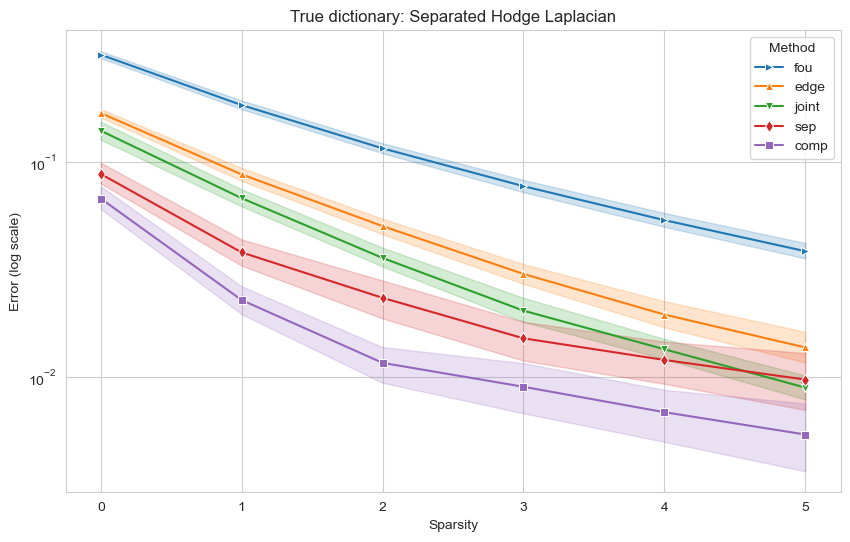

<Axes: title={'center': 'True dictionary: Separated Hodge Laplacian'}, xlabel='Sparsity', ylabel='Error (log scale)'>

In [6]:
plot_error_curves(res,"sep")

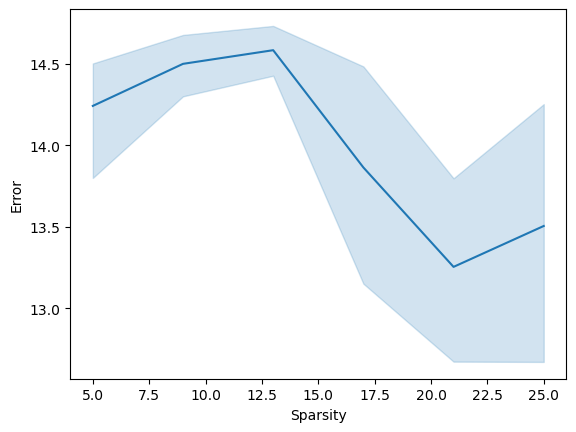

In [69]:
import seaborn as sns 
import matplotlib.pyplot as plt

tmp_df = pd.DataFrame(res["comp"][2])
tmp_df.columns = K0_coll
tmp_df = tmp_df.melt(var_name="Sparsity", value_name="Error")

plot1= sns.lineplot(data=tmp_df,
        x="Sparsity",
        y="Error")
plt.show()

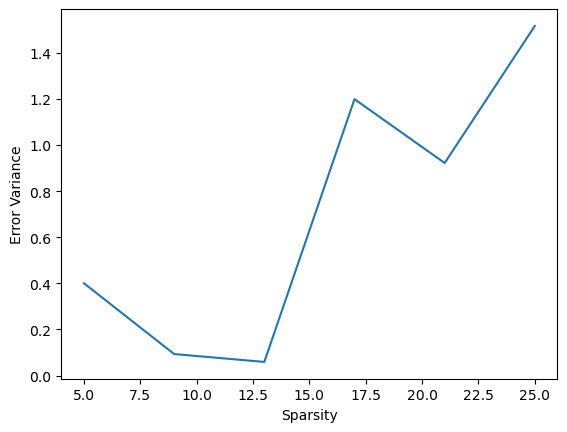

In [70]:
plot2 = sns.lineplot(data=tmp_df,
        x="Sparsity",
        y="Error",estimator=np.var,errorbar=None)
plot2.set_ylabel("Error Variance")
plt.show()

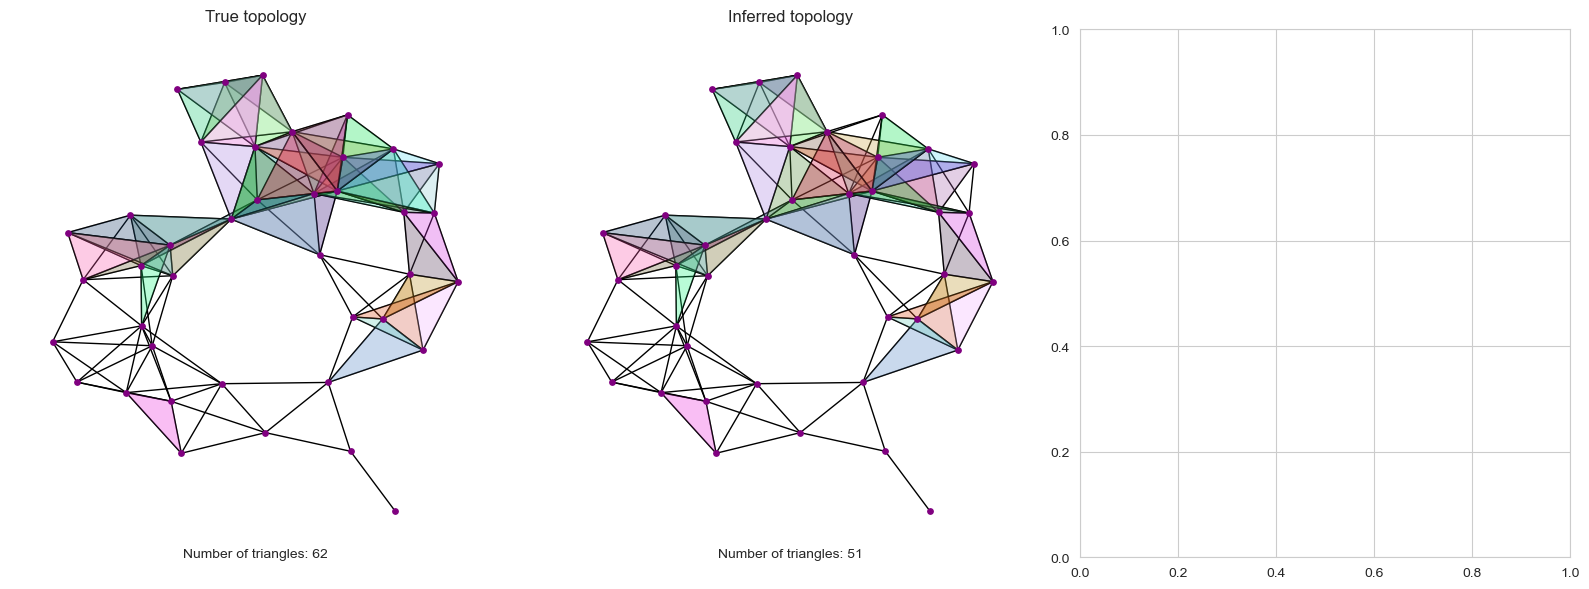

In [10]:
plot_learnt_topology(G, B2, models["0,0"])

In [4]:
import seaborn as sns
sns.color_palette()[:5]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]